# LoRa Data Analysis - Adaptive Data Rate


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Bandwidth: 125 kHz

End nodes:
- used an adaptive data rate algorithm (ADR) for communication parameters selection.

Access points:
- two access points were used to avoid a duty cycle depletion

Initial declaration

In [488]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib_inline as mpl_inl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

mpl_inl.backend_inline.set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable
subfolder = 's1r1'
algorithm = 'adr'
uplink_message_file = './data/' + algorithm + '/' + subfolder + '/uplink_messages.csv'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [489]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [490]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,...,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id,dev_id,application_id,battery
0,39039,QjVCQkJCAA==,11.50,-59,33704,t,2023-09-20 18:45:08.249,2595,866100000,11,...,-1276574632,4/5,125000,22,1,777777,zMzM,39009,NaN,NaN
1,39040,QjVCQkJCAA==,9.50,-66,33704,t,2023-09-20 18:45:08.706,37730,866500000,11,...,-1276573828,4/5,125000,17,1,777777,u7u7,39010,NaN,NaN
2,39041,QjVCQkJCAA==,8.75,-78,32386,t,2023-09-20 18:45:12.737,49485,866300000,11,...,-1276570095,4/5,125000,105,1,777777,VVVV,39011,NaN,NaN
3,39042,QjVCQkJCAA==,8.50,-56,31440,t,2023-09-20 18:45:16.273,18305,866100000,11,...,-1276566584,4/5,125000,23,1,777777,iIiI,39012,NaN,NaN
4,39043,QjVCQkJCAA==,6.25,-60,31440,t,2023-09-20 18:45:18.777,6981,866900000,12,...,-1276563930,4/5,125000,27,1,777777,qqqq,39013,NaN,NaN


Let us have a look for different values to get an overview of overall values of different network parameters.

In [491]:
uplink_data.describe()

,id,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,bandwidth,msg_group_number,message_type_id,ap_id,dev_id,application_id,battery
count,4536.00000,4536.000000,4536.000000,4536.000000,4536.000000,4.536000e+03,4536.000000,4536.0,4.536000e+03,4536.0,4536.000000,4536.0,4536.000000,4536.00000,0.0,0.0
mean,41306.50000,9.108796,-79.473325,12491.217593,32524.766755,8.664132e+08,9.907407,0.0,-1.216840e+09,125000.0,250.164021,1.0,559768.203704,41276.50000,NaN,NaN
std,1309.57474,2.927926,13.276043,11383.923092,19234.384408,3.234638e+05,1.912018,0.0,3.081689e+07,0.0,146.418783,0.0,222206.551446,1309.57474,NaN,NaN
min,39039.00000,-13.750000,-119.000000,1.000000,133.000000,8.661000e+08,7.000000,0.0,-1.276575e+09,125000.0,16.000000,1.0,333333.000000,39009.00000,NaN,NaN
25%,40172.75000,8.250000,-89.000000,714.000000,14233.750000,8.661000e+08,8.000000,0.0,-1.244050e+09,125000.0,140.000000,1.0,333333.000000,40142.75000,NaN,NaN
50%,41306.50000,9.500000,-80.000000,10370.000000,31779.500000,8.663000e+08,11.000000,0.0,-1.207969e+09,125000.0,229.000000,1.0,777777.000000,41276.50000,NaN,NaN
75%,42440.25000,10.750000,-71.000000,21779.000000,47394.000000,8.667000e+08,12.000000,0.0,-1.189627e+09,125000.0,328.000000,1.0,777777.000000,42410.25000,NaN,NaN
max,43574.00000,14.750000,-49.000000,36000.000000,65534.000000,8.669000e+08,12.000000,0.0,-1.182088e+09,125000.0,685.000000,1.0,777777.000000,43544.00000,NaN,NaN


### Payload Length

In [492]:
uplink_data['payload_len'] = uplink_data.app_data.apply(len)
uplink_data.payload_len.describe()

count    4536.0
mean       12.0
std         0.0
min        12.0
25%        12.0
50%        12.0
75%        12.0
max        12.0
Name: payload_len, dtype: float64

In [493]:
payload_len = round(statistics.mean(uplink_data.payload_len), 2)
print(f'Mean value of payload length is {payload_len}.')

Mean value of payload length is 12.


### Spreading Factor

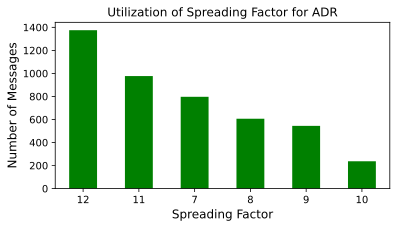

In [494]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='g',figsize=(6,3))
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Spreading Factor for {algorithm.upper()}')
# plt.savefig(f'./{subfolder}/{algorithm}-speading-factor.svg', dpi=300)
plt.show()

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [495]:
uplink_frequency = uplink_data.frequency / 1000000

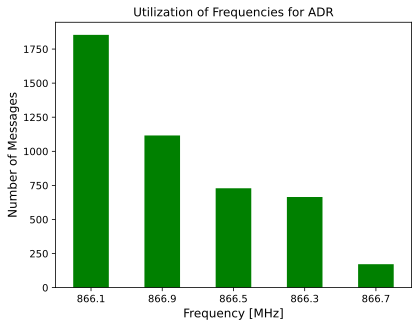

In [496]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='g')
hist.set_xlabel('Frequency [MHz]',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Frequencies for {algorithm.upper()}')
#plt.savefig(f'./{subfolder}/{algorithm}-frequencies.svg', dpi=300)
plt.show()

### Unique Uplink Messages

In [497]:
unique_messages = uplink_data[uplink_data.is_primary=="t"]
print(f'Uplink messages received during experiment: {len(unique_messages)}')

Uplink messages received during experiment: 3314


### Received Signal Strength Indicator

In [498]:
x = unique_messages.id
y = unique_messages.rssi
hist.set_xlabel('Time', fontsize=12)
#hist.set_ylabel('Number of Messages', fontsize=12)

# size and color:
sizes = np.random.uniform(15, 80, len(x))

# Define the colormap 'Greens' which is a gradient of green
cmap = plt.get_cmap('Greens')

# Define vmin and vmax values to control the gradient
vmin = 0.2
vmax = 0.8

# Generate random values within the range [vmin, vmax]
normalized_values = (np.random.rand(len(x)) * (vmax - vmin)) + vmin

fig, ax = plt.subplots()
sc = ax.scatter(x, y, s=sizes, c=normalized_values, cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar for reference
cbar = plt.colorbar(sc)
cbar.set_label('Color Range')

ax.set_xticks([])

plt.title(f'RSSI values in time for {algorithm.upper()}')
#plt.savefig(f'./{subfolder}/{algorithm}-rssi.svg', dpi=300)
plt.show()

## Analysis of End Nodes

Analysis of certain aspects of end devices.

In [499]:
uplink_data.node_id.unique()
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 10.


In [500]:
uplink_data.node_id.describe()

count     4536
unique      10
top       VVVV
freq       829
Name: node_id, dtype: object

In [501]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 10
Total number of connected access points: 2


## Packet Delivery Raio

Evaluation of PDR for end nodes.

In [502]:
end_nodes = unique_messages.groupby('node_id')

seq_tolerance = 15
first_seq = 0
last_seq = 0
prev_seq = 0
prev_node_id = ""
msg_count = 0
msg_delivered = 0
total_msg_count = 0

for name,group in end_nodes:
    #print('ID:' + str(name))
    #print(group['seq'])

    for seq in group['seq']:
        #print(name, seq)
        if (abs(prev_seq - seq) > seq_tolerance):
            total_msg_count += prev_seq - first_seq
            #print(prev_node_id, prev_seq, seq, first_seq, prev_seq - first_seq, msg_count)
            msg_delivered += msg_count
            first_seq = seq
            msg_count = 0
        if prev_seq != seq:
            msg_count += 1
        prev_seq = seq
        prev_node_id = name
    if total_msg_count != 0:
        pdr = min(round(msg_delivered / total_msg_count * 100, 2), 100.0)
    else:
        pdr = 0.0
    print(f'{name} reached PDR {pdr}%')
    first_seq = 0
    last_seq = 0
    prev_seq = 0
    msg_count = 0
    msg_delivered = 0
    total_msg_count = 0


3d3d reached PDR 76.49%
7u7u reached PDR 70.98%
VVVV reached PDR 66.93%
ZmZm reached PDR 72.12%
d3d3 reached PDR 70.3%
iIiI reached PDR 71.54%
mZmZ reached PDR 61.78%
qqqq reached PDR 65.66%
u7u7 reached PDR 63.22%
zMzM reached PDR 71.32%


### Number of unique message per end node

In [503]:
unique_message_counts = unique_messages['node_id'].value_counts().reset_index()
unique_message_counts.columns = ['node_id', 'messages_count']
unique_message_counts['pdr'] = round((unique_message_counts.messages_count / 154) * 100, 2)
print(unique_message_counts)

  node_id  messages_count     pdr
0    VVVV             581  377.27
1    u7u7             444  288.31
2    ZmZm             354  229.87
3    d3d3             339  220.13
4    mZmZ             322  209.09
5    zMzM             286  185.71
6    7u7u             278  180.52
7    iIiI             274  177.92
8    3d3d             251  162.99
9    qqqq             185  120.13


The End.